In [34]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [35]:
import pandas as pd

df = pd.read_csv("C:\Downloads\spam (1).csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [36]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [37]:
df['Category'].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [38]:
747/4825

0.15481865284974095

**countering imbalance in the dataset**

In [39]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [40]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [41]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [42]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [43]:
df_balanced['Category'].value_counts()

Category
ham     747
spam    747
Name: count, dtype: int64

In [44]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
5181,ham,K sure am in my relatives home. Sms me de. Pls:-),0
910,spam,"January Male Sale! Hot Gay chat now cheaper, c...",1
1364,ham,"Yetunde, i'm sorry but moji and i seem too bus...",0
19,spam,England v Macedonia - dont miss the goals/team...,1
1659,spam,RGENT! This is the 2nd attempt to contact U!U ...,1


<h4>Split it into training and test data set</h4>

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [46]:
X_train.head(4)

4003    Did you get any gift? This year i didnt get an...
5079    Do you want a New Nokia 3510i colour phone Del...
3537    Oic cos me n my sis got no lunch today my dad ...
2328    URGENT! Your mobile number *************** WON...
Name: Message, dtype: object

<h4>Model building through pretrained model(BERT)</h4>

In [47]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [48]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351707, -0.5132728 , -0.8884573 , ..., -0.74748874,
        -0.7531475 ,  0.9196451 ],
       [-0.8720836 , -0.50543994, -0.9444668 , ..., -0.858475  ,
        -0.71745366,  0.88082975]], dtype=float32)>

In [49]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [50]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [51]:
len(X_train)

1120

In [52]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=METRICS)

<h4>Train the model</h4>

In [53]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 33s 777ms/step - loss: 0.6737 - accuracy: 0.5696 - precision: 0.5670 - recall: 0.5893
Epoch 2/10
35/35 [==============================] - 27s 782ms/step - loss: 0.5652 - accuracy: 0.7732 - precision: 0.7752 - recall: 0.7696
Epoch 3/10
35/35 [==============================] - 28s 788ms/step - loss: 0.5134 - accuracy: 0.8205 - precision: 0.8166 - recall: 0.8268
Epoch 4/10
35/35 [==============================] - 28s 801ms/step - loss: 0.4761 - accuracy: 0.8375 - precision: 0.8182 - recall: 0.8679
Epoch 5/10
35/35 [==============================] - 28s 790ms/step - loss: 0.4495 - accuracy: 0.8509 - precision: 0.8382 - recall: 0.8696
Epoch 6/10
35/35 [==============================] - 28s 790ms/step - loss: 0.4289 - accuracy: 0.8536 - precision: 0.8345 - recall: 0.8821
Epoch 7/10
35/35 [==============================] - 28s 789ms/step - loss: 0.4106 - accuracy: 0.8616 - precision: 0.8534 - recall: 0.8732
Epoch 8/10
35/35 [================

In [54]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 10s 771ms/step - loss: 0.3915 - accuracy: 0.8824 - precision: 0.8950 - recall: 0.8663


[0.3914543688297272, 0.8823529481887817, 0.8950276374816895, 0.866310179233551]

In [55]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 9s 788ms/step


In [56]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,

In [57]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[168,  19],
       [ 25, 162]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

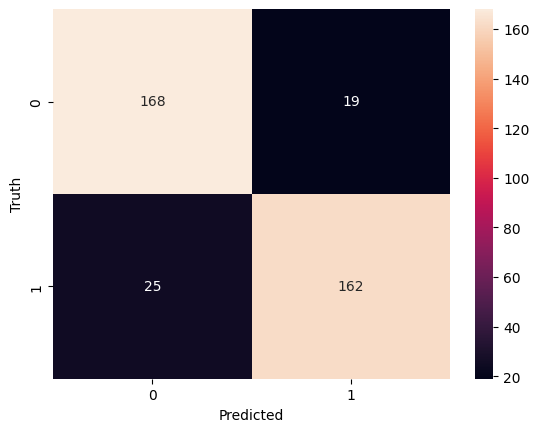

In [60]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [61]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       187
           1       0.90      0.87      0.88       187

    accuracy                           0.88       374
   macro avg       0.88      0.88      0.88       374
weighted avg       0.88      0.88      0.88       374



##### predication

In [62]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'til 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 1s 713ms/step


array([[0.60322064],
       [0.31341597],
       [0.2816965 ],
       [0.20215198]], dtype=float32)